<a href="https://colab.research.google.com/github/pthnhan/DS_KHTN_TimeSeries/blob/main/h.w/TimeSeriesAnalysisAndForcasting_Wiley/Nhom5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, acf, plot_pacf
!pip install scikit-gstat
import skgstat as skg
import seaborn as sns
import statistics
from statsmodels.graphics import gofplots


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Problem 2.1**

**Consider the US Treasury Securities rate data in Table B.1 (Appendix B). Find the sample autocorrelation function and the variogram for these data. Is the time series stationary or nonstationary?**

Sử dụng data "US Treasury Securities rate" trong giai đoạn 1/04/1953 - 01/09 1996, có tất cả 126 sample, hình ảnh cho thấy dạng dữ liệu như sau:

In [ ]:
data_2_1 = pd.read_excel("https://github.com/pthnhan/DS_KHTN_TimeSeries/blob/main/data/Time%20Series%20and%20Forecasting%20Appendix%20B%20Tables.xls?raw=true", sheet_name='B.1-10YTCM')

In [ ]:
data_2_1.columns = data_2_1.iloc[2].values
data_2_1 = data_2_1.drop([0,1,2], axis = 0)

In [ ]:
data_2_1.head()

,Month,"Rate, %",Month,"Rate, %",Month,"Rate, %",Month,"Rate, %"
3,1953-04-01 00:00:00,2.83,1966-10-01 00:00:00,5.01,1980-04-01 00:00:00,11.47,1993-10-01 00:00:00,5.33
4,1953-05-01 00:00:00,3.05,1966-11-01 00:00:00,5.16,1980-05-01 00:00:00,10.18,1993-11-01 00:00:00,5.72
5,1953-06-01 00:00:00,3.11,1966-12-01 00:00:00,4.84,1980-06-01 00:00:00,9.78,1993-12-01 00:00:00,5.77
6,1953-07-01 00:00:00,2.93,1967-01-01 00:00:00,4.58,1980-07-01 00:00:00,10.25,1994-01-01 00:00:00,5.75
7,1953-08-01 00:00:00,2.95,1967-02-01 00:00:00,4.63,1980-08-01 00:00:00,11.1,1994-02-01 00:00:00,5.97


In [ ]:
df = pd.concat([data_2_1.iloc[:,[0,1]],data_2_1.iloc[:,[2,3]], data_2_1.iloc[:,[4,5]]], ignore_index=True)

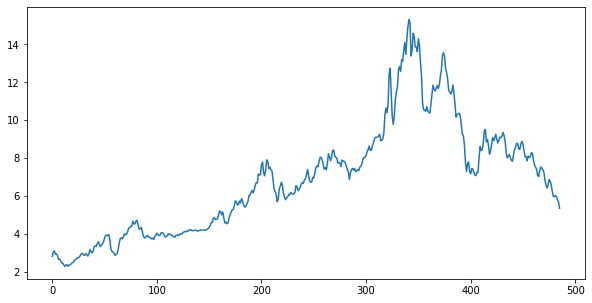

In [ ]:
plt.figure(figsize= (10,5))
plt.plot(df['Rate, %'])
plt.savefig('dt2_1.png')
plt.show()

In [ ]:
y_mean = df['Rate, %'].mean()

df['c0'] = pow(df['Rate, %'] - y_mean,2)
df['c1'] = (df['Rate, %'] - y_mean)*(df.iloc[1::]['Rate, %'].reset_index(drop=True) - y_mean)

c0 = df['c0'].mean()
c1 = df['c1'].mean()

#Calculate ACF at lag = 1
r = c1/c0
r

0.9950133095766169

In [ ]:
#using statsmodels to check result
import statsmodels.api as sm
r = sm.tsa.acf(df['Rate, %'], nlags=1)
print(r)

[1.0 0.9929659570877761]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



In [ ]:
df['Rate, %'] = pd.to_numeric(df['Rate, %'])

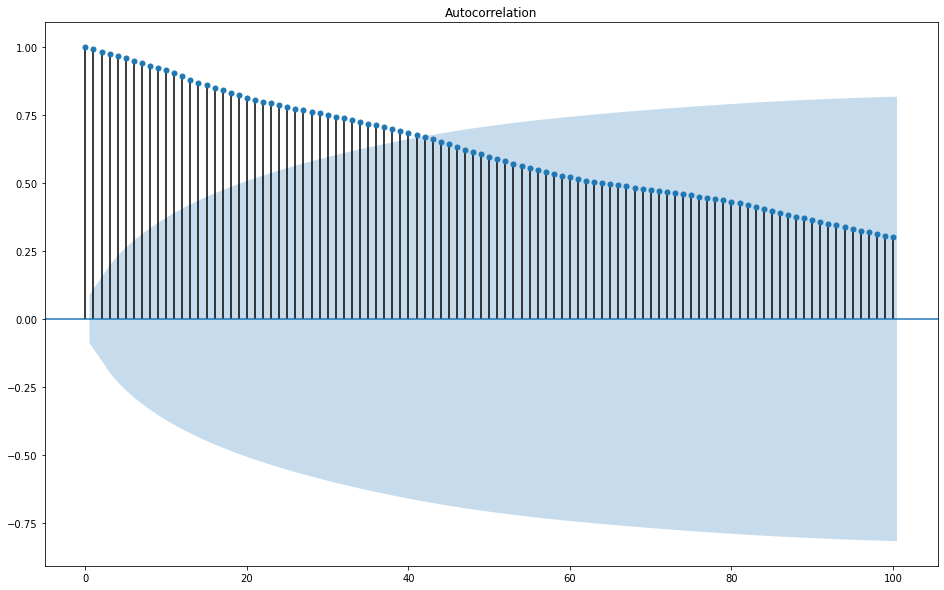

In [ ]:
fig = sm.graphics.tsa.plot_acf(df['Rate, %'], lags=100)
fig.set_size_inches(16,10)
# fig.savefig('ACF_1.png')

In [ ]:
def est_dk(data,k):
  d_k = []
  for ind, value in enumerate(data):
    if  ind < (data.shape[0] - k):
      d_k.append(data[ind+k] - data[ind])
  return np.array(d_k), np.array(d_k).mean()

def est_std(data,k):
  dk, dk_mean = est_dk(data,k)
  dk_square = 0
  for ind, value in enumerate(data):
    if  ind < (data.shape[0] - k):
      dk_square += np.square(dk[ind] - dk_mean) 
  return dk_square/(data.shape[0] - k -1)

def Variogram(data,lags):
  std_1 = est_std(data,1)
  variograms = []
  for lag in range(1,lags+1):
    sdt_k = est_std(data,lag)
    variograms.append(sdt_k/std_1) 
  return variograms


In [ ]:
Variograms = Variogram(df['Rate, %'], 100)
df_Varios = pd.DataFrame(Variograms, columns=['Variogram'])

In [ ]:
df_Varios

,Variogram
0,1.000000
1,2.653087
2,4.065984
3,5.346363
4,6.630434
...,...
95,114.654573
96,115.452077
97,116.237472
98,116.998211


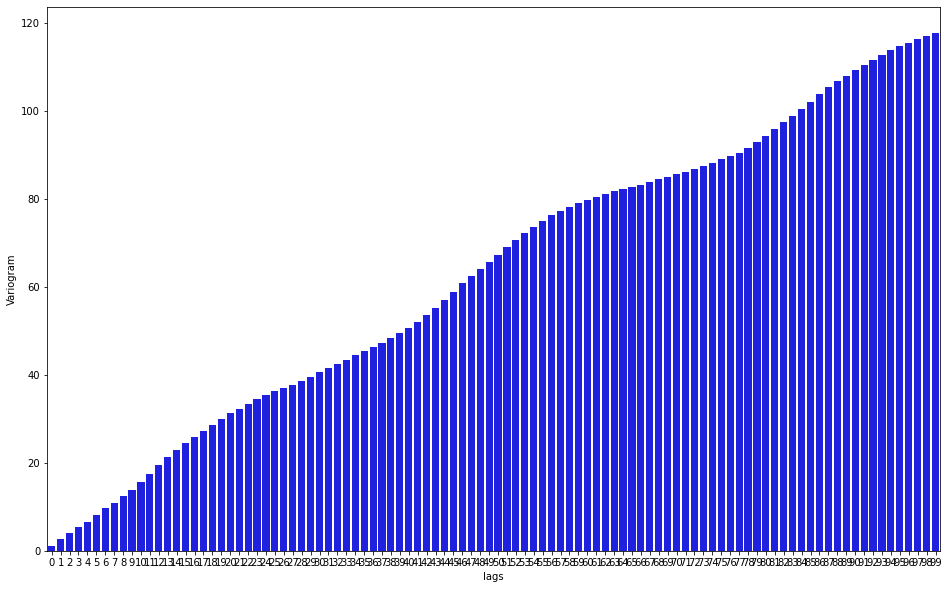

In [ ]:
plt.figure(figsize= (16,10))
ax = sns.barplot(x = df_Varios.index,y = df_Varios.Variogram, color = 'blue')
plt.xlabel('lags')
plt.show()

In [ ]:
df

,Month,"Rate, %",c0,c1
0,1953-04-01 00:00:00,2.83,16.1544,15.2702
1,1953-05-01 00:00:00,3.05,14.4344,14.2064
2,1953-06-01 00:00:00,3.11,13.9821,14.6551
3,1953-07-01 00:00:00,2.93,15.3606,15.2822
4,1953-08-01 00:00:00,2.95,15.2042,15.5162
...,...,...,...,...
481,1993-05-01 00:00:00,6.04,0.654901,0.719641
482,1993-06-01 00:00:00,5.96,0.790782,0.924171
483,1993-07-01 00:00:00,5.81,1.08006,1.21516
484,1993-08-01 00:00:00,5.68,1.36717,1.74133


**#Nhận xét: Vì biểu đồ Variogram tăng đều liên tục theo độ trễ và không có sự thay đổi bất chợt nên dữ liệu chuỗi thời gian là nonstationary**

# **Problem 2.2**

**Consider the data on US production of blue and gorgonzola cheeses in Table B.4.**

**a. Find the sample autocorrelation function and the variogram for these data. Is the time series stationary or nonstationary?**

**b. Take the first difference of the time series, then find the sample autocorrelation function and the variogram. What conclusions can you draw about the structure and behavior of the time series?**

In [ ]:
data_2_2 = pd.read_excel("https://github.com/pthnhan/DS_KHTN_TimeSeries/blob/main/data/Time%20Series%20and%20Forecasting%20Appendix%20B%20Tables.xls?raw=true", sheet_name='B.4-BLUE', header = 3).set_index('Year')
display(data_2_2.shape)
data_2_2


(48, 1)

,"Production, thousand lbs"
Year,
1950,7657
1951,5451
1952,10883
1953,9554
1954,9519
1955,10047
1956,10663
1957,10864
1958,11447


**a.**

**ACF**

[ 1.          0.92255797  0.85024468  0.79968986  0.74328987  0.69263229
  0.64664768  0.59209915  0.52647671  0.4652179   0.39867153  0.34387841
  0.28989096  0.2233688   0.15486809  0.09742316  0.05132157  0.01216789
 -0.04327517 -0.10876777 -0.17264515 -0.22894671 -0.27937815 -0.30055353
 -0.31694514 -0.35312179 -0.38708335 -0.3941504  -0.39437517 -0.38682199
 -0.37532855 -0.36851273 -0.37764654 -0.38354729 -0.37991077 -0.36492428
 -0.34974284 -0.3415661  -0.3222856  -0.29379332 -0.27001317 -0.23817501
 -0.21282921 -0.19269725 -0.16909106 -0.13552361 -0.11006524 -0.05872958]


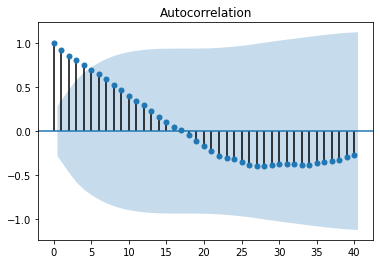

In [ ]:
acf = sm.tsa.stattools.acf(data_2_2['Production, thousand lbs'], nlags = len(data_2_2)-1, fft=False)
print(acf)
plot_acf(data_2_2['Production, thousand lbs'], lags=40)
plt.show()

**Variogram**

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   47.00
Sill:              313988849.54
Nugget:            0.00
        


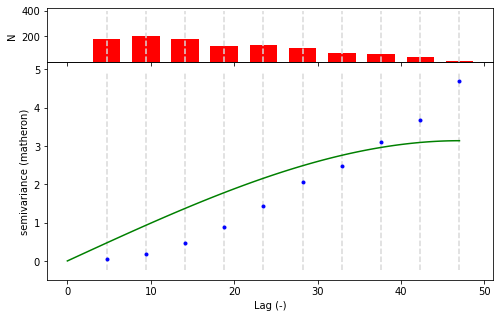

In [ ]:
v = skg.Variogram(data_2_2.index.tolist(), data_2_2['Production, thousand lbs'].tolist())
print(v)
v.plot()
plt.show()

In [ ]:
data_2_2['Production, thousand lbs'].values

array([ 7657,  5451, 10883,  9554,  9519, 10047, 10663, 10864, 11447,
       12710, 15169, 16205, 14507, 15400, 16800, 19000, 20198, 18573,
       19375, 21032, 23250, 25219, 28549, 29759, 28262, 28506, 33885,
       34776, 35347, 34628, 33043, 30214, 31013, 31496, 34115, 33433,
       34198, 35863, 37789, 34561, 36434, 34371, 33307, 33295, 36514,
       36593, 38311, 42773])

In [ ]:
variogram_2_2 = Variogram(data_2_2['Production, thousand lbs'].values, 47)
df_Varios_2_2 = pd.DataFrame(variogram_2_2, columns=['Variogram'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in double_scalars



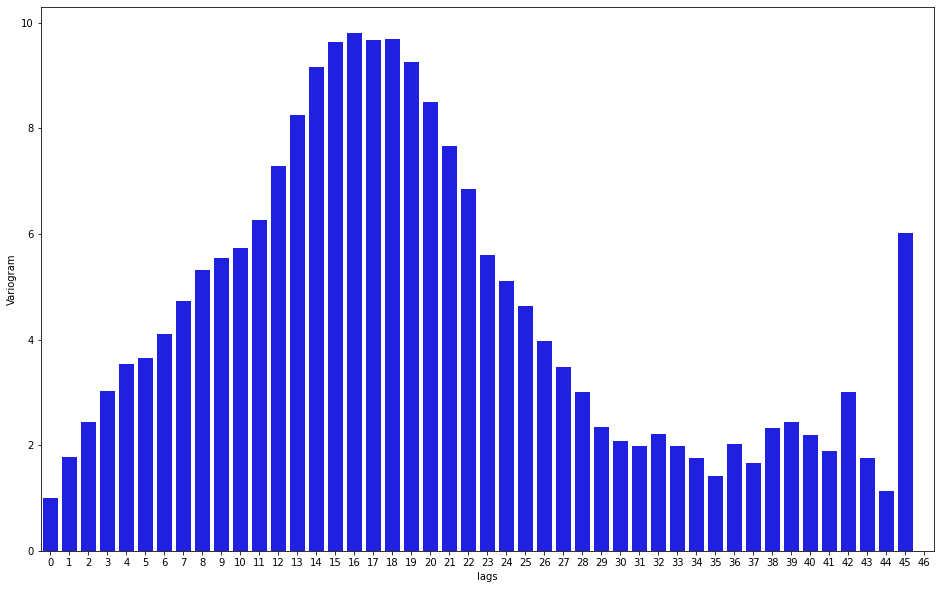

In [ ]:
plt.figure(figsize= (16,10))
ax = sns.barplot(x = df_Varios_2_2.index,y = df_Varios_2_2.Variogram, color = 'blue')
plt.xlabel('lags')
plt.show()

**Is the time series stationary or nonstationary?**



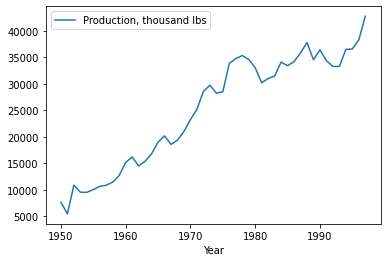

In [ ]:
data_2_2.plot()
plt.show()

**Trả lời**

Tuy đồ thị Variogram có tăng giảm đột ngột, nhưng dựa vào đồ thị của dữ liệu trên, ta thấy rằng đồ thị có trend rõ ràng. Ngoài ra, dựa vào đồ thị của ACF, giá trị ACF giảm về 0 tương đối chậm, và giá trị r1 tương đối lớn. Do đó có thể kết luận ngay được rằng time series trên là **nonstationary**.

**b.**

**Take the first difference of the time series**

In [ ]:
data_2_2_firstdiff = data_2_2.diff().dropna()
data_2_2_firstdiff

,"Production, thousand lbs"
Year,
1951,-2206.0
1952,5432.0
1953,-1329.0
1954,-35.0
1955,528.0
1956,616.0
1957,201.0
1958,583.0
1959,1263.0


**ACF**

[ 1.00000000e+00 -6.82867752e-02 -5.54875457e-02 -7.59062679e-02
  3.61830729e-02 -2.09835764e-01  9.29855566e-02  1.26327888e-02
 -8.00875848e-03 -1.82478560e-01 -3.41368410e-02  1.39213515e-01
  1.69669952e-01 -4.31327754e-02 -3.59377467e-02 -1.76245565e-01
 -1.05020894e-01 -7.72670686e-02  1.01504339e-01 -7.99065203e-02
 -6.32973135e-02  6.32854355e-03 -7.43714392e-02 -6.71022453e-02
  2.16083890e-01  1.79422870e-04  2.03311457e-02  4.68412083e-02
  2.00169779e-02 -5.12504496e-02  3.03007344e-02 -2.44593916e-02
  5.43834180e-02 -5.98778336e-02  3.43633146e-02 -1.48520977e-02
  7.89738124e-02 -9.47859215e-02  1.54152336e-01 -8.06951741e-02
 -1.50057715e-02 -2.06715632e-02  8.01415801e-02 -9.02226585e-02
 -7.00069733e-03  8.54346557e-02 -6.44766237e-02]


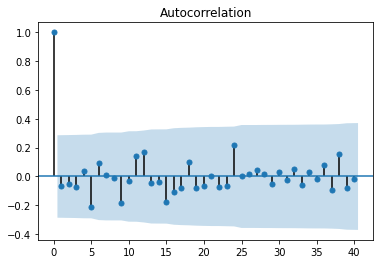

In [ ]:
acf_firstdiff = sm.tsa.stattools.acf(data_2_2_firstdiff['Production, thousand lbs'], nlags = len(data_2_2_firstdiff)-1,fft=False)
print(acf_firstdiff)
plot_acf(data_2_2_firstdiff['Production, thousand lbs'], lags=40)
plt.show()

**Variogram**

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   6.93
Sill:              4105574.82
Nugget:            0.00
        


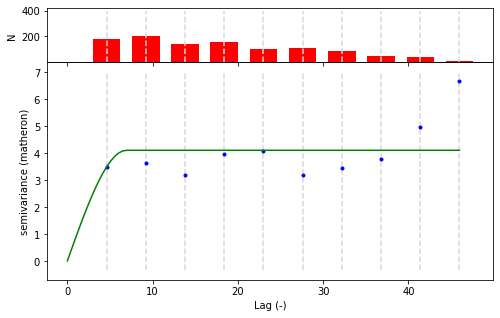

In [ ]:
v_firstdiff = skg.Variogram(data_2_2_firstdiff.index.tolist(), data_2_2_firstdiff['Production, thousand lbs'].tolist())
print(v_firstdiff)
v_firstdiff.plot()
plt.show()

**What conclusions can you draw about the structure and behavior of the time series?**

**Trả lời**

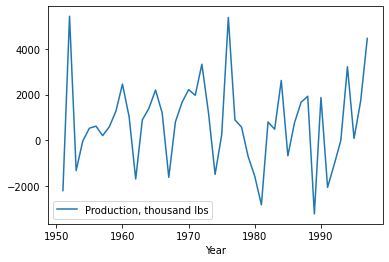

In [ ]:
data_2_2_firstdiff.plot()
plt.show()

Sau khi lấy first difference của time series trên. Ta thấy rằng, time series mới là một **stationary**. Vì đồ thị của dữ liệu không có trend, và đồ thị AFC của time series trên dao động gần 0.

# **Problem 2.3**

**Table B.5 contains the US beverage product shipments data. Find the sample autocorrelation function and the variogram for these data. Is the time series stationary or nonstationary?**

In [ ]:
data_2_3 = pd.read_excel("https://github.com/pthnhan/DS_KHTN_TimeSeries/blob/main/data/Time%20Series%20and%20Forecasting%20Appendix%20B%20Tables.xls?raw=true", sheet_name='B.5-BEV')

In [ ]:
data_2_3

,"Table B.5 U.S. Beverage Manufacturer Product Shipments, Unadjusted",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,Source: http://www.census.gov/indicator/www/m3...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Month,"Dollars, in Millions",Month,"Dollars, in Millions",Month,"Dollars, in Millions",Month,"Dollars, in Millions"
3,1992-01-01 00:00:00,3519,1995-10-01 00:00:00,4681,1999-07-01 00:00:00,5339,2003-04-01 00:00:00,5576
4,1992-02-01 00:00:00,3803,1995-11-01 00:00:00,4466,1999-08-01 00:00:00,5474,2003-05-01 00:00:00,6160
5,1992-03-01 00:00:00,4332,1995-12-01 00:00:00,4463,1999-09-01 00:00:00,5278,2003-06-01 00:00:00,6121
6,1992-04-01 00:00:00,4251,1996-01-01 00:00:00,4217,1999-10-01 00:00:00,5184,2003-07-01 00:00:00,5900
7,1992-05-01 00:00:00,4661,1996-02-01 00:00:00,4322,1999-11-01 00:00:00,4975,2003-08-01 00:00:00,5994
8,1992-06-01 00:00:00,4811,1996-03-01 00:00:00,4779,1999-12-01 00:00:00,4751,2003-09-01 00:00:00,5841
9,1992-07-01 00:00:00,4448,1996-04-01 00:00:00,4988,2000-01-01 00:00:00,4600,2003-10-01 00:00:00,5832


In [ ]:
data_2_3.columns = data_2_3.iloc[2].values
data_2_3.drop([0, 1, 2], axis=0, inplace=True)

In [ ]:
df = pd.concat([data_2_3.iloc[:,[0,1]],data_2_3.iloc[:,[2,3]], data_2_3.iloc[:,[4,5]], data_2_3.iloc[:,[6,7]]],  ignore_index=True)

In [ ]:
df

,Month,"Dollars, in Millions"
0,1992-01-01 00:00:00,3519
1,1992-02-01 00:00:00,3803
2,1992-03-01 00:00:00,4332
3,1992-04-01 00:00:00,4251
4,1992-05-01 00:00:00,4661
...,...,...
175,2006-08-01 00:00:00,7039
176,2006-09-01 00:00:00,6440
177,2006-10-01 00:00:00,6446
178,2006-11-01 00:00:00,6717


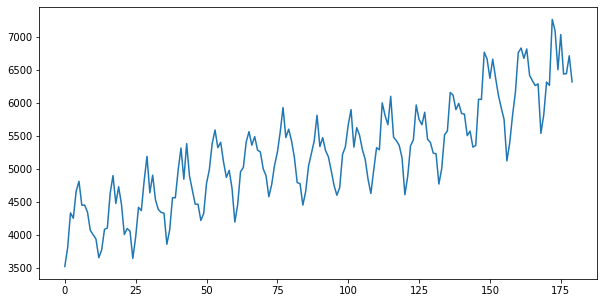

In [ ]:
plt.figure(figsize= (10,5))
plt.plot(df['Dollars, in Millions'])
# plt.savefig('dt2_1.png')
plt.show()

In [ ]:
y_mean = df['Dollars, in Millions'].mean()

df['c0'] = pow(df['Dollars, in Millions'] - y_mean,2)
df['c1'] = (df['Dollars, in Millions'] - y_mean)*(df.iloc[1::]['Dollars, in Millions'].reset_index(drop=True) - y_mean)

c0 = df['c0'].mean()
c1 = df['c1'].mean()

#Calculate ACF at lag = 1
r = c1/c0
r

0.8989964419182143

In [ ]:
#using statsmodels to check result
import statsmodels.api as sm
r = sm.tsa.acf(df['Dollars, in Millions'], nlags=1)
print(r)

[1.0 0.8940020172408908]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



In [ ]:
df['Dollars, in Millions'] = pd.to_numeric(df['Dollars, in Millions'])

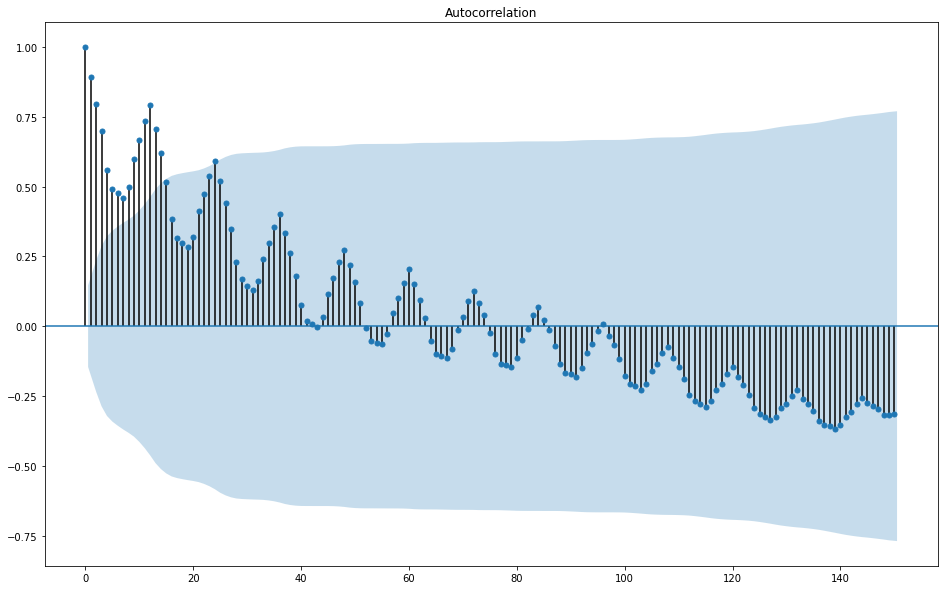

In [ ]:
fig = sm.graphics.tsa.plot_acf(df['Dollars, in Millions'], lags=150)
fig.set_size_inches(16,10)

In [ ]:
def est_dk(data,k):
  d_k = []
  for ind, value in enumerate(data):
    if  ind < (data.shape[0] - k):
      d_k.append(data[ind+k] - data[ind])
  return np.array(d_k), np.array(d_k).mean()

def est_std(data,k):
  dk, dk_mean = est_dk(data,k)
  dk_square = 0
  for ind, value in enumerate(data):
    if  ind < (data.shape[0] - k):
      dk_square += np.square(dk[ind] - dk_mean) 
  return dk_square/(data.shape[0] - k -1)

def Variogram(data,lags):
  std_1 = est_std(data,1)
  variograms = []
  for lag in range(1,lags+1):
    sdt_k = est_std(data,lag)
    variograms.append(sdt_k/std_1) 
  return variograms

In [ ]:
Variograms = Variogram(df['Dollars, in Millions'], 175)
df_Varios = pd.DataFrame(Variograms, columns=['Variogram'])

In [ ]:
df_Varios

,Variogram
0,1.000000
1,1.902546
2,2.907220
3,4.421872
4,5.037049
...,...
170,2.743224
171,5.404736
172,3.889260
173,3.832275


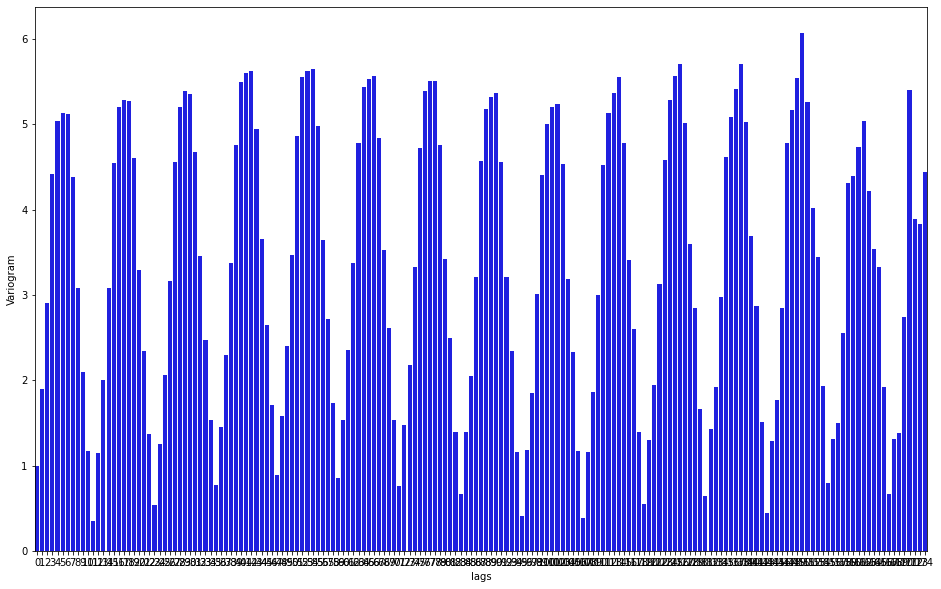

In [ ]:
plt.figure(figsize= (16,10))
ax = sns.barplot(x = df_Varios.index,y = df_Varios.Variogram, color = 'blue')
plt.xlabel('lags')
plt.show()

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   179.00
Sill:              1786647.08
Nugget:            0.00
        


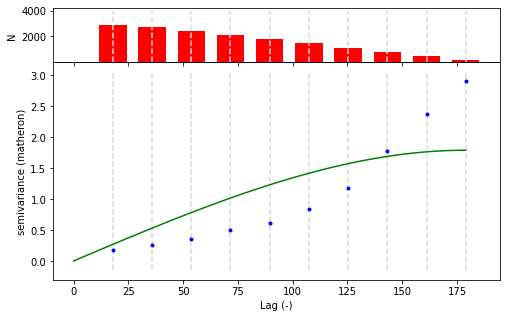

In [ ]:
v = skg.Variogram(df.index.tolist(), df['Dollars, in Millions'].tolist())
print(v)
v.plot()
plt.show()

**Is the time series stationary or nonstationary?**

Trả lời: Từ đồ thị ta thấy được dữ liệu có khuynh hướng tăng rồi giảm sau mỗi năm theo một pattern nhất định nhưng tổng quan thì có trend tăng. Vì vậy ta có thể kết luận đây là một TS non-stationary

# **Problem 2.4**

**Table B.6 contains two time series: the global mean surface air temperature anomaly and the global CO2 concentration. Find the sample autocorrelation function and the variogram for both of these time series. Is either one of the time series stationary?**

In [ ]:
data_2_4 = pd.read_excel("https://github.com/pthnhan/DS_KHTN_TimeSeries/blob/main/data/Time%20Series%20and%20Forecasting%20Appendix%20B%20Tables.xls?raw=true", sheet_name='B.6-GSAT-CO2')

In [ ]:
data_2_4

,Table B.6 Global Mean Surface Air Temperature Anomaly and Global CO2 Concentration,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,Source: http://data.giss.nasa.gov/gistemp/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Year,"Anomaly, C","CO2, ppmv",NaN,Year,"Anomaly, C","CO2, ppmv",NaN,Year,"Anomaly, C","CO2, ppmv"
3,1880,-0.11,290.7,NaN,1922,-0.09,303.8,NaN,1964,-0.25,319.2
4,1881,-0.13,291.2,NaN,1923,-0.16,304.1,NaN,1965,-0.15,320.015
5,1882,-0.01,291.7,NaN,1924,-0.11,304.5,NaN,1966,-0.07,321.085
6,1883,-0.04,292.1,NaN,1925,-0.15,305,NaN,1967,-0.02,321.99
7,1884,-0.42,292.6,NaN,1926,0.04,305.4,NaN,1968,-0.09,322.925
8,1885,-0.23,293,NaN,1927,-0.05,305.8,NaN,1969,0,324.21
9,1886,-0.25,293.3,NaN,1928,0.01,306.3,NaN,1970,0.04,325.24


In [ ]:
data_2_4.columns = data_2_4.iloc[2].values
data_2_4.drop([0, 1, 2], axis=0, inplace=True)


In [ ]:
data_2_4.columns

Index([      'Year', 'Anomaly, C',  'CO2, ppmv',          nan,       'Year',
       'Anomaly, C',  'CO2, ppmv',          nan,       'Year', 'Anomaly, C',
        'CO2, ppmv'],
      dtype='object')

In [ ]:
df = pd.concat([data_2_4.iloc[:,[0,1,2]], data_2_4.iloc[:,[4,5,6]], data_2_4.iloc[:,[8, 9, 10]]],  ignore_index=True)

In [ ]:
df.dropna(axis=0, inplace=True)

In [ ]:
df

,Year,"Anomaly, C","CO2, ppmv"
0,1880,-0.11,290.7
1,1881,-0.13,291.2
2,1882,-0.01,291.7
3,1883,-0.04,292.1
4,1884,-0.42,292.6
...,...,...,...
120,2000,0.41,369.48
121,2001,0.56,371.02
122,2002,0.7,373.1
123,2003,0.66,375.64


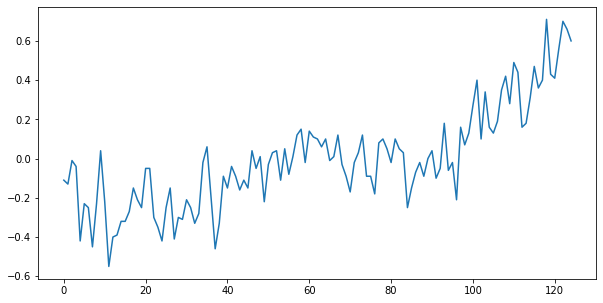

In [ ]:
plt.figure(figsize= (10,5))
plt.plot(df['Anomaly, C'])
# plt.savefig('dt2_1.png')
plt.show()

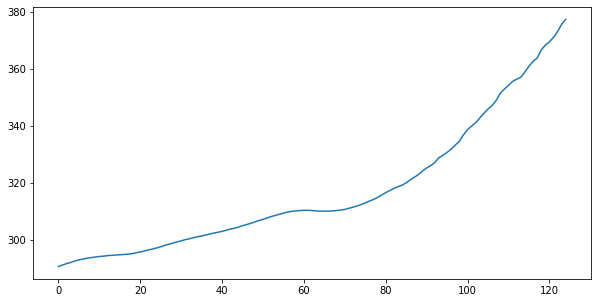

In [ ]:
plt.figure(figsize= (10,5))
plt.plot(df['CO2, ppmv'])
plt.show()

In [ ]:
#using statsmodels to check result
import statsmodels.api as sm
r1 = sm.tsa.acf(df['Anomaly, C'], nlags=1)
print(r1)

[1.0 0.80719477835584]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



In [ ]:
import statsmodels.api as sm
r2 = sm.tsa.acf(df['CO2, ppmv'], nlags=1)
print(r2)

[1.0 0.9661034684873915]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



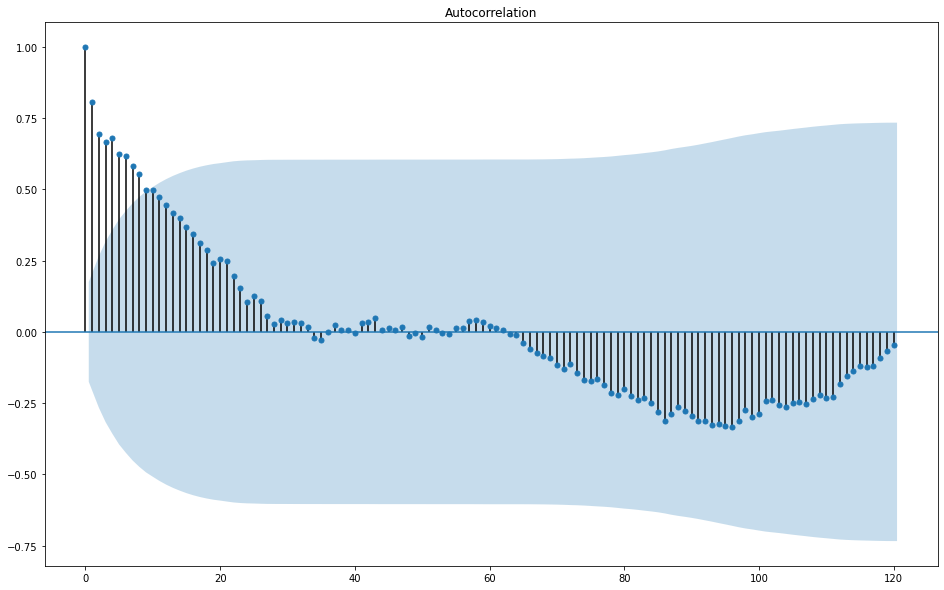

In [ ]:
df['Anomaly, C'] = pd.to_numeric(df['Anomaly, C'])
fig = sm.graphics.tsa.plot_acf(df['Anomaly, C'], lags=120)
fig.set_size_inches(16,10)

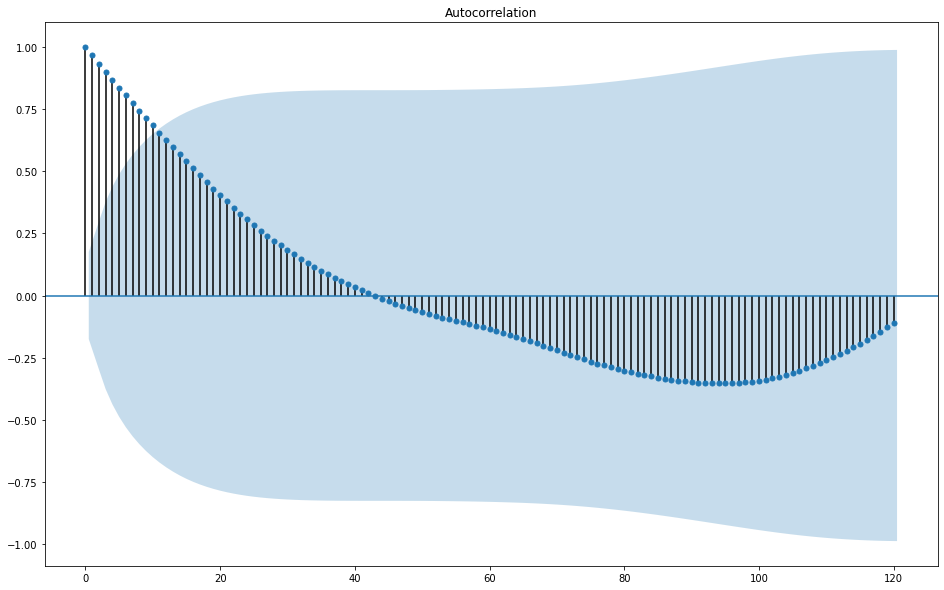

In [ ]:
df['CO2, ppmv'] = pd.to_numeric(df['CO2, ppmv'])
fig = sm.graphics.tsa.plot_acf(df['CO2, ppmv'], lags=120)
fig.set_size_inches(16,10)

In [ ]:
def est_dk(data,k):
  d_k = []
  for ind, value in enumerate(data):
    if  ind < (data.shape[0] - k):
      d_k.append(data[ind+k] - data[ind])
  return np.array(d_k), np.array(d_k).mean()

def est_std(data,k):
  dk, dk_mean = est_dk(data,k)
  dk_square = 0
  for ind, value in enumerate(data):
    if  ind < (data.shape[0] - k):
      dk_square += np.square(dk[ind] - dk_mean) 
  return dk_square/(data.shape[0] - k -1)

def Variogram(data,lags):
  std_1 = est_std(data,1)
  variograms = []
  for lag in range(1,lags+1):
    sdt_k = est_std(data,lag)
    variograms.append(sdt_k/std_1) 
  return variograms

In [ ]:
Variograms_1 = Variogram(df['Anomaly, C'], 120)
df_Varios_1 = pd.DataFrame(Variograms_1, columns=['Variogram'])

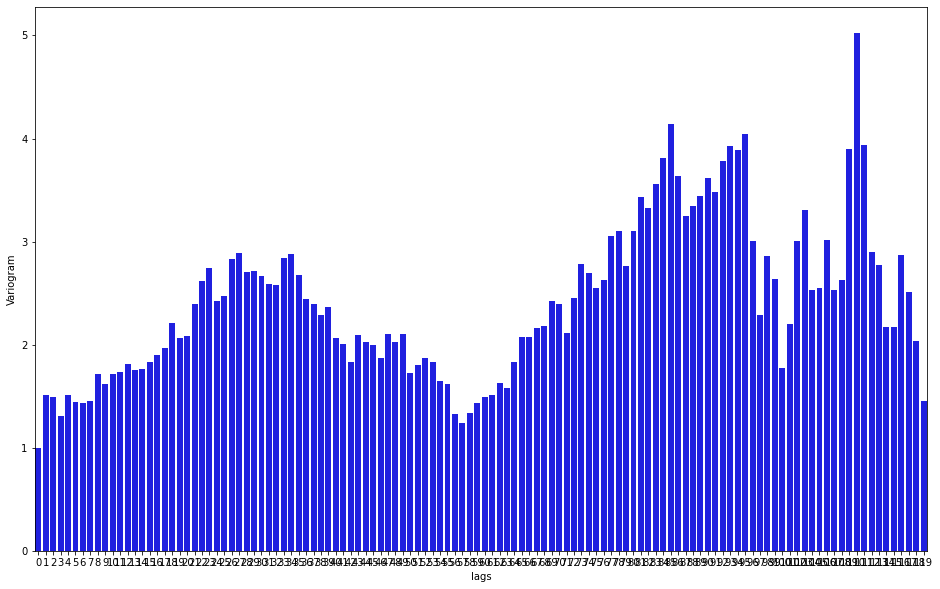

In [ ]:
plt.figure(figsize= (16,10))
ax = sns.barplot(x = df_Varios_1.index,y = df_Varios_1.Variogram, color = 'blue')
plt.xlabel('lags')
plt.show()

In [ ]:
Variograms_2 = Variogram(df['CO2, ppmv'], 120)
df_Varios_2 = pd.DataFrame(Variograms_2, columns=['Variogram'])

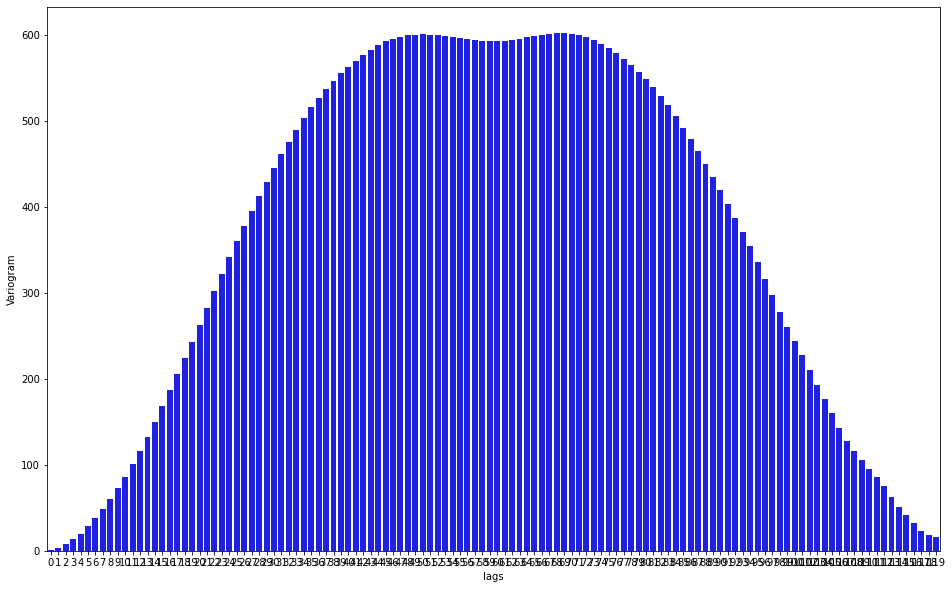

In [ ]:
plt.figure(figsize= (16,10))
ax = sns.barplot(x = df_Varios_2.index,y = df_Varios_2.Variogram, color = 'blue')
plt.xlabel('lags')
plt.show()

**Is either one of the time series stationary?**

Từ các đồ thị mô tả dữ liệu ta thấy cả hai chuỗi thời gian này đều có khuynh hướng tăng dần theo thời gian. Ngoài ra 

# **Problem 2.9**

**Table B.9 contains the annual International Sunspot Numbers. Find the sample autocorrelation function and the variogram for this time series. Is the time series stationary or nonstationary?**

In [ ]:
data_2_9 = pd.read_excel("https://github.com/pthnhan/DS_KHTN_TimeSeries/blob/main/data/Time%20Series%20and%20Forecasting%20Appendix%20B%20Tables.xls?raw=true", sheet_name='B.9-SUNSPOT', header = 3)
data_2_9.columns = ['Year', 'Sunspot Number', 'Year', 'Sunspot Number', 'Year', 'Sunspot Number', 'Year', 'Sunspot Number', 'Year', 'Sunspot Number']
#concat
data_2_9 = pd.concat([data_2_9.iloc[:,:2], data_2_9.iloc[:,2:4], data_2_9.iloc[:,4:6], data_2_9.iloc[:,6:8], data_2_9.iloc[:,8:]]).set_index('Year')
display(data_2_9.shape)
data_2_9

(305, 1)

,Sunspot Number
Year,
1700,5.1
1701,11.1
1702,16.1
1703,23.1
1704,36.1
...,...
2000,119.7
2001,111.1
2002,104.1


**ACF**

[ 1.00000000e+00  8.20628018e-01  4.51115403e-01  4.02846392e-02
 -2.72584346e-01 -4.17231778e-01 -3.64051317e-01 -1.43951220e-01
  1.69992984e-01  4.79970165e-01  6.60999921e-01  6.48122087e-01
  4.53642022e-01  1.60613755e-01 -1.18313312e-01 -3.05470496e-01
 -3.56084503e-01 -2.83294965e-01 -1.15960509e-01  1.03951931e-01
  2.99879157e-01  4.17840106e-01  4.10529450e-01  2.73552007e-01
  5.45989641e-02 -1.58665355e-01 -3.08792953e-01 -3.50623459e-01
 -2.67853575e-01 -1.08718317e-01  8.20665072e-02  2.43577756e-01
  3.23358742e-01  2.82065782e-01  1.38694939e-01 -5.19641033e-02
 -2.23009156e-01 -3.04464005e-01 -2.81179262e-01 -1.67838472e-01
 -1.02240147e-02  1.36552761e-01  2.25716227e-01  2.21546017e-01
  1.39804952e-01  1.37389563e-02 -1.04734466e-01 -1.67687153e-01
 -1.73206512e-01 -1.22530900e-01 -4.05652832e-02  4.62934373e-02
  9.67279806e-02  1.06236120e-01  7.30886202e-02  2.41753658e-02
 -2.74741362e-02 -6.66226851e-02 -8.19740614e-02 -8.45525123e-02
 -7.77924890e-02 -5.56819

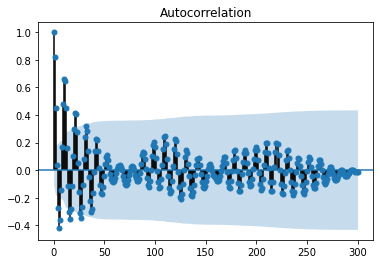

In [ ]:
acf = sm.tsa.stattools.acf(data_2_9['Sunspot Number'], nlags = len(data_2_9)-1, fft=False)
print(acf)
plot_acf(data_2_9['Sunspot Number'], lags=300)
plt.show()

**Variogram**

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   49.72
Sill:              1875.89
Nugget:            0.00
        


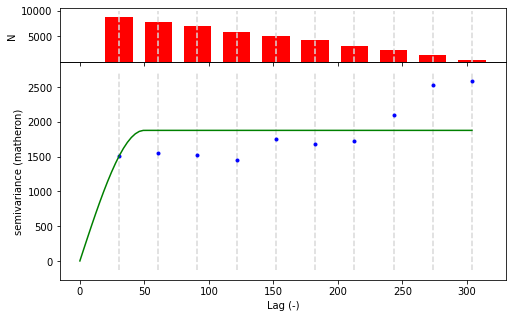

In [ ]:
v = skg.Variogram(data_2_9.index.tolist(), data_2_9['Sunspot Number'].tolist())
print(v)
v.plot()
plt.show()

**Is the time series stationary or nonstationary?**

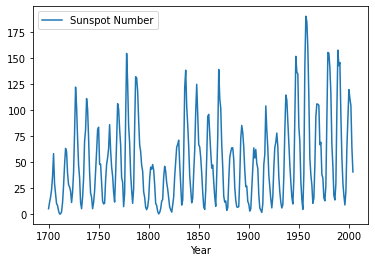

In [ ]:
data_2_9.plot()
plt.show()

Từ đồ thị của dữ liệu time series trên và đồ thị của ACF dao động gần 0. Ta có thể kết luận được, time series trên là **nonstationary**.

# **Problem 2.10**

**Table B.10 contains data on the number of airline miles flown in the United Kingdom. This is strongly seasonal data. Find the sample autocorrelation function for this time series.**

**a. Is the seasonality apparent in the sample autocorrelation function?**

**b. Is the time series stationary or nonstationary?**

**Find the sample autocorrelation function for this time series.**

In [ ]:
data_2_10 = pd.read_excel("https://github.com/pthnhan/DS_KHTN_TimeSeries/blob/main/data/Time%20Series%20and%20Forecasting%20Appendix%20B%20Tables.xls?raw=true", sheet_name="B.10-FLOWN", header=3).set_index('Month')
display(data_2_10.shape)
data_2_10

(84, 1)

,"Miles, in Millions"
Month,
1964-01-01,7.269
1964-02-01,6.775
1964-03-01,7.819
1964-04-01,8.371
1964-05-01,9.069
...,...
1970-08-01,14.057
1970-09-01,16.234
1970-10-01,12.389


[ 1.          0.74257119  0.54336185  0.44939621  0.12823271 -0.02094057
  0.0165085  -0.04583603  0.09076271  0.35250531  0.40477457  0.50428895
  0.6357869   0.46483167  0.31003237  0.21917975 -0.03929781 -0.17799279
 -0.15081571 -0.20090608 -0.0811005   0.11670717  0.16576018  0.30725249
  0.4109607   0.28273336  0.16739425  0.07354613 -0.12699535 -0.22974673
 -0.22184494 -0.2604044  -0.1508615   0.01761371  0.05301584  0.16926601
  0.25657089  0.1575738   0.07503164 -0.00577647 -0.17677804 -0.25662641
 -0.26328881 -0.28766974 -0.20680977 -0.09346058 -0.05836963  0.02599638
  0.08205036  0.02429216 -0.0157467  -0.08011336 -0.18983239 -0.23898255
 -0.29036581 -0.31549654 -0.24124965 -0.16525724 -0.1174261  -0.05390335
 -0.02487804 -0.0577248  -0.09337743 -0.14313832 -0.22954592 -0.2529464
 -0.24699908 -0.23943476 -0.19272981 -0.14239183 -0.12339112 -0.10065773
 -0.08486974 -0.10252739 -0.12241485 -0.12518079 -0.13808247 -0.14183687
 -0.12646143 -0.11665753 -0.08848889 -0.04111669 -0.

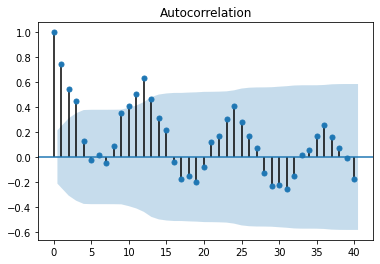

In [ ]:
acf = sm.tsa.stattools.acf(data_2_10['Miles, in Millions'], nlags = len(data_2_10)-1,fft=False)
print(acf)
plot_acf(data_2_10['Miles, in Millions'], lags=40)
plt.show()

**a.**

**Is the seasonality apparent in the sample autocorrelation function?**

**Trả lời**

Từ đồ thị của ACF, ta thấy rằng, dữ liệu có tính mùa do ACF lên xuống theo chu kì.

**b.**

**Is the time series stationary or nonstationary?**

**Trả lời**

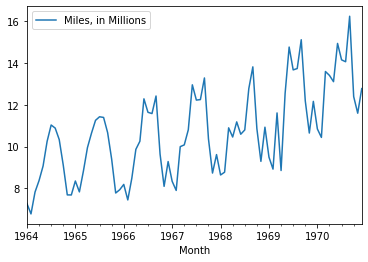

In [ ]:
data_2_10.plot()
plt.show()

Tuy đồ thị của dữ liệu có trend tăng qua các năm, tuy nhiên, xét theo tháng thì đồ thị có sự lặp lại lên xuống. Hơn nữa, đồ thị AFC dao động quanh 0. Do đó, ta có thể kết luận rằng time series trên là **stationary**.

# **Problem 2.19**
**Table B.16 presents data on the US Gross Domestic Product (GDP). Plot the GDP data and calculate the sample autocorrelation function and variogram. Is there an indication of nonstationary behavior in the time series? Now plot the first difference of the GDP time series and compute the sample autocorrelation function and variogram of the first differences. What impact has differencing had on the time series?**

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, acf, plot_pacf
!pip install scikit-gstat
import skgstat as skg

In [ ]:
data_2_19 = pd.read_excel("https://github.com/pthnhan/DS_KHTN_TimeSeries/blob/main/data/Time%20Series%20and%20Forecasting%20Appendix%20B%20Tables.xls?raw=true", sheet_name='B.16-GDP', header = 3).set_index('Year')
display(data_2_19.shape)
data_2_19


(74, 2)

,"GDP, Current Dollars, billions","GDP, Real (1996) Dollars, billions"
Year,,
1929,103.7,822.2
1930,91.3,751.5
1931,76.6,703.6
1932,58.8,611.8
1933,56.4,603.3
...,...,...
1998,8781.5,8508.9
1999,9274.3,8859.0
2000,9824.6,9191.4


**Plot data**

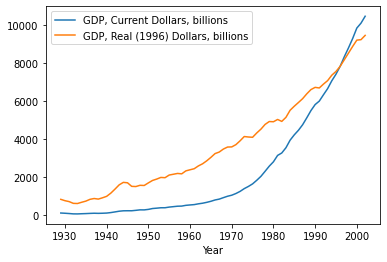

In [ ]:
data_2_19.plot()
plt.show()

**ACF**

GDP, Current Dollars, billions
[ 1.          0.94369095  0.88716853  0.82921223  0.773631    0.71998541
  0.66812525  0.61881766  0.57114784  0.52436058  0.47939975  0.43531071
  0.39236303  0.34886825  0.30660616  0.26661032  0.22877808  0.19220714
  0.15645722  0.12223274  0.09112781  0.06174366  0.03237958  0.00587269
 -0.01903044 -0.04167931 -0.0620629  -0.08066595 -0.09765347 -0.11363083
 -0.12882241 -0.14267233 -0.15561026 -0.16787485 -0.17979914 -0.19113334
 -0.20173385 -0.21195197 -0.22141903 -0.23034902 -0.23871622 -0.24668609
 -0.2542143  -0.26144855 -0.2682776  -0.27432652 -0.28010755 -0.28532962
 -0.28980834 -0.29330773 -0.29604148 -0.29772274 -0.29850951 -0.2976981
 -0.29622053 -0.29391712 -0.29002764 -0.28498492 -0.27920534 -0.27245981
 -0.26424703 -0.25430449 -0.24286204 -0.23047434 -0.21682233 -0.20197057
 -0.18575531 -0.16822376 -0.14910789 -0.12812298 -0.10538671 -0.08094843
 -0.05481241 -0.02795951]


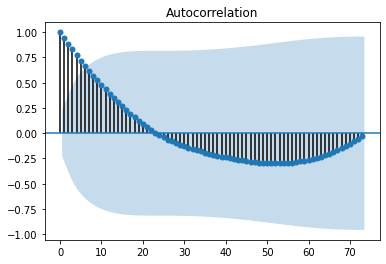

GDP, Real (1996) Dollars, billions
[ 1.          0.95436942  0.90780324  0.85842687  0.81003957  0.76354818
  0.71930641  0.67738352  0.6370939   0.59712451  0.55833861  0.52005795
  0.48252698  0.44350849  0.40514173  0.3689101   0.33471022  0.30092259
  0.26676251  0.23362783  0.20388201  0.17520258  0.1442766   0.11390944
  0.0823125   0.05151069  0.02224724 -0.00513985 -0.03069521 -0.05751177
 -0.08610108 -0.11219821 -0.13663636 -0.16029301 -0.18419727 -0.20740412
 -0.22888477 -0.24939113 -0.26722871 -0.28298167 -0.29640232 -0.30838527
 -0.3191789  -0.3293091  -0.33828681 -0.3447716  -0.35242378 -0.36017297
 -0.36662214 -0.37060361 -0.37373985 -0.3753793  -0.37656656 -0.37583661
 -0.37439353 -0.37212135 -0.36730053 -0.36178093 -0.35784437 -0.35341458
 -0.34625561 -0.33531233 -0.32132058 -0.30557946 -0.28778837 -0.26808932
 -0.24700592 -0.22414897 -0.19838299 -0.16966152 -0.13793222 -0.10407922
 -0.06928787 -0.03490204]


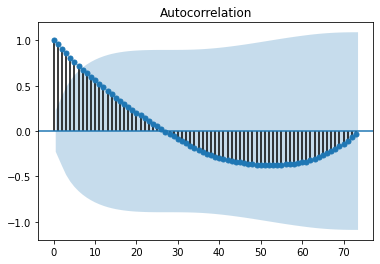

In [ ]:
print("GDP, Current Dollars, billions")
acf1 = sm.tsa.stattools.acf(data_2_19['GDP, Current Dollars, billions'], nlags = len(data_2_19)-1,fft=False)
print(acf1)
plot_acf(data_2_19['GDP, Current Dollars, billions'], lags=73)
plt.show()
print("GDP, Real (1996) Dollars, billions")
acf2 = sm.tsa.stattools.acf(data_2_19['GDP, Real (1996) Dollars, billions'], nlags = len(data_2_19)-1,fft=False)
print(acf2)
plot_acf(data_2_19['GDP, Real (1996) Dollars, billions'], lags=73)
plt.show()

**Variogram**

GDP, Current Dollars, billions
spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   73.00
Sill:              26728741.25
Nugget:            0.00
        


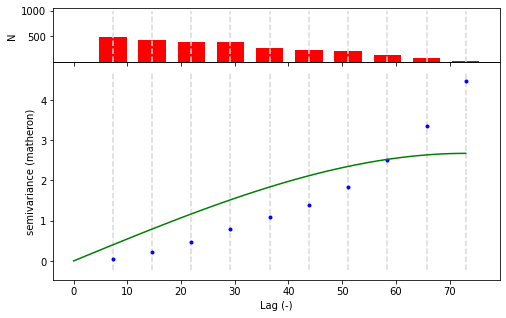

GDP, Real (1996) Dollars, billions
spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   73.00
Sill:              20584856.64
Nugget:            0.00
        


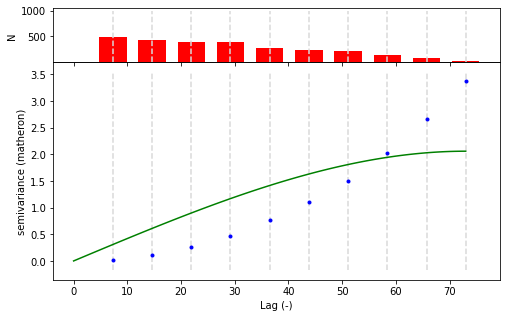

In [ ]:
print("GDP, Current Dollars, billions")
v_curr = skg.Variogram(data_2_19.index.tolist(), data_2_19['GDP, Current Dollars, billions'].tolist())
print(v_curr)
v_curr.plot()
plt.show()
print("GDP, Real (1996) Dollars, billions")
v_real = skg.Variogram(data_2_19.index.tolist(), data_2_19['GDP, Real (1996) Dollars, billions'].tolist())
print(v_real)
v_real.plot()
plt.show()

**Is there an indication of nonstationary behavior in the time series?**

**Trả lời**

Từ đồ thị của time series trên, cả 2 GDP đều có trend tăng. Ngoài ra, đồ thị ACF giảm chậm về 0. Do đó, ta có thể thấy rằng, cả 2 timeseries trên đều **nonstationary**.

**Take the first difference of the GDP time series**

In [ ]:
data_2_19_firstdiff = data_2_19.diff().dropna()
data_2_19_firstdiff

,"GDP, Current Dollars, billions","GDP, Real (1996) Dollars, billions"
Year,,
1930,-12.4,-70.7
1931,-14.7,-47.9
1932,-17.8,-91.8
1933,-2.4,-8.5
1934,9.6,65.0
...,...,...
1998,463.1,349.4
1999,492.8,350.1
2000,550.3,332.4


**Plot the first difference of the GDP time series**

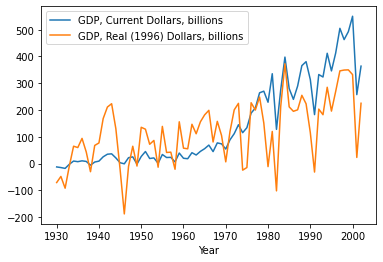

In [ ]:
data_2_19_firstdiff.plot()
plt.show()

**ACF of the first differences**

GDP, Current Dollars, billions
[ 1.          0.89377295  0.8649704   0.82158698  0.77026712  0.73288254
  0.66965508  0.61326376  0.6032562   0.55901163  0.53785293  0.50185394
  0.4692047   0.43951847  0.38713348  0.35733297  0.33260449  0.27247955
  0.23930377  0.2135396   0.15045937  0.14203224  0.08617089  0.03946361
  0.00319841 -0.0430329  -0.07331601 -0.10628316 -0.12865719 -0.15398622
 -0.17801537 -0.19654507 -0.21734898 -0.22648923 -0.24372561 -0.26413979
 -0.27340988 -0.28111756 -0.29779102 -0.3124123  -0.32016996 -0.32571094
 -0.33231872 -0.33706447 -0.34051726 -0.34170773 -0.34593073 -0.34206474
 -0.34557395 -0.33418638 -0.32887834 -0.32490484 -0.3107751  -0.31587681
 -0.305583   -0.2846138  -0.27640511 -0.27058844 -0.26151795 -0.24781913
 -0.23403708 -0.22484776 -0.22644163 -0.2106807  -0.19946244 -0.17932973
 -0.16541441 -0.14724807 -0.11923591 -0.09317026 -0.06443404 -0.02909652
 -0.01893883]


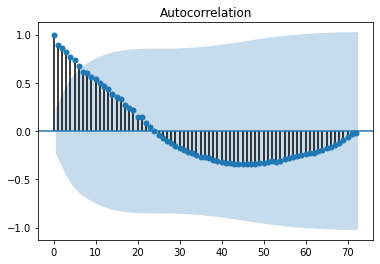

GDP, Real (1996) Dollars, billions
[ 1.00000000e+00  5.07459877e-01  2.89313289e-01  1.53887786e-01
  9.37081900e-02  1.67409227e-01  1.37100228e-01  1.48311349e-01
  2.16086266e-01  1.23738838e-01  1.55116682e-01  2.04645164e-01
  1.81269207e-01  1.63534102e-01  1.51213130e-01  1.44643973e-01
  1.71803955e-01  2.02345684e-02 -2.44053418e-02  3.26963451e-02
  1.32644527e-02  1.82079567e-01  1.20886531e-01  4.78944740e-02
  7.65954423e-02  9.42182860e-03  3.50155492e-02 -4.90430188e-02
  2.04534618e-02  3.41069762e-03 -4.36243098e-02 -5.54402018e-02
 -1.03314658e-01  1.65693313e-03  2.88788855e-02 -4.97079470e-03
  1.34007385e-03 -4.06372983e-02 -1.81957892e-01 -2.02196852e-01
 -1.74474969e-01 -1.35125948e-01 -7.96171442e-02 -4.81184303e-02
 -1.78717775e-02 -3.84780088e-02 -1.58806866e-01 -1.13204249e-01
 -1.59193988e-01 -1.11229263e-01 -1.12851778e-01 -1.75042902e-01
 -1.52744430e-01 -1.89697031e-01 -1.58046112e-01 -5.19057487e-02
 -6.14975941e-02 -5.87080965e-02 -6.12081149e-02 -6.552

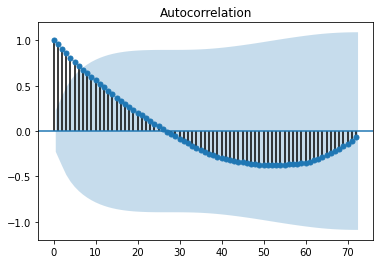

In [ ]:
print("GDP, Current Dollars, billions")
acf1_firstdiff = sm.tsa.stattools.acf(data_2_19_firstdiff['GDP, Current Dollars, billions'], nlags = len(data_2_19_firstdiff)-1,fft=False)
print(acf1_firstdiff)
plot_acf(data_2_19_firstdiff['GDP, Current Dollars, billions'], lags=72)
plt.show()
print("GDP, Real (1996) Dollars, billions")
acf2_firstdiff = sm.tsa.stattools.acf(data_2_19_firstdiff['GDP, Real (1996) Dollars, billions'], nlags = len(data_2_19_firstdiff)-1,fft=False)
print(acf2_firstdiff)
plot_acf(data_2_19['GDP, Real (1996) Dollars, billions'], lags=72)
plt.show()

**Variogram of the first differences**

GDP, Current Dollars, billions
spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   72.00
Sill:              67602.52
Nugget:            0.00
        


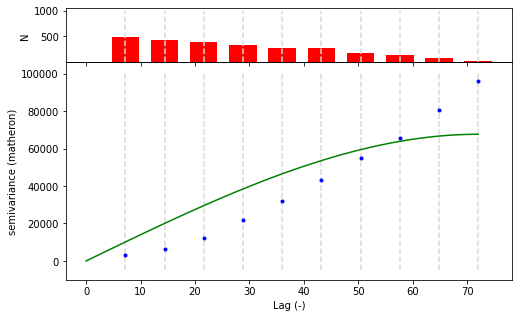

GDP, Real (1996) Dollars, billions
spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   72.00
Sill:              29436.78
Nugget:            0.00
        


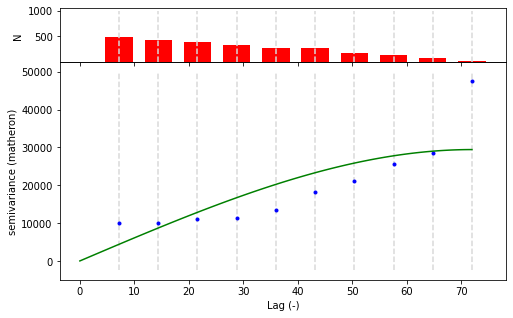

In [ ]:
print("GDP, Current Dollars, billions")
v_curr_firstdiff = skg.Variogram(data_2_19_firstdiff.index.tolist(), data_2_19_firstdiff['GDP, Current Dollars, billions'].tolist())
print(v_curr_firstdiff)
v_curr_firstdiff.plot()
plt.show()
print("GDP, Real (1996) Dollars, billions")
v_real_firstdiff = skg.Variogram(data_2_19_firstdiff.index.tolist(), data_2_19_firstdiff['GDP, Real (1996) Dollars, billions'].tolist())
print(v_real_firstdiff)
v_real_firstdiff.plot()
plt.show()

**What impact has differencing had on the time series?**

**Trả lời**

...

# **Problem 2.31**

**Table B.2 contains annual US motor vehicle traffic fatalities along
with other information. Plot the data and comment on any features
that you observe from the graph. Calculate and plot the sample ACF
and variogram. Interpret these graphs.**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm

%matplotlib inline

In [ ]:
data = pd.read_csv("https://github.com/pthnhan/DS_KHTN_TimeSeries/raw/main/data/Table%20B.25-US%20Motor%20Vehicle%20Traffic%20Fatalities.csv")

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
data

,Year,Fatalities,Resident Population (Thousands),Licensed Drivers (Thousands),Registered Motor Vehicles (Thousands),Vehicle Miles Traveled (Billions),Annual Unemplyment Rate (%)
0,1966,50894,196560,100998,95703,926,3.8
1,1967,50724,198712,103172,98859,964,3.8
2,1968,52725,200706,105410,102987,1016,3.6
3,1969,53543,202677,108306,107412,1062,3.5
4,1970,52627,205052,111543,111242,1110,4.9
5,1971,52542,207661,114426,116330,1179,5.9
6,1972,54589,209896,118414,122557,1260,5.6
7,1973,54052,211909,121546,130025,1313,4.9
8,1974,45196,213854,125427,134900,1281,5.6
9,1975,44525,215973,129791,126153,1328,8.5


In [ ]:
data_df = data.set_index("Year")

**Plot the data and comment on any features that you observe from the graph**

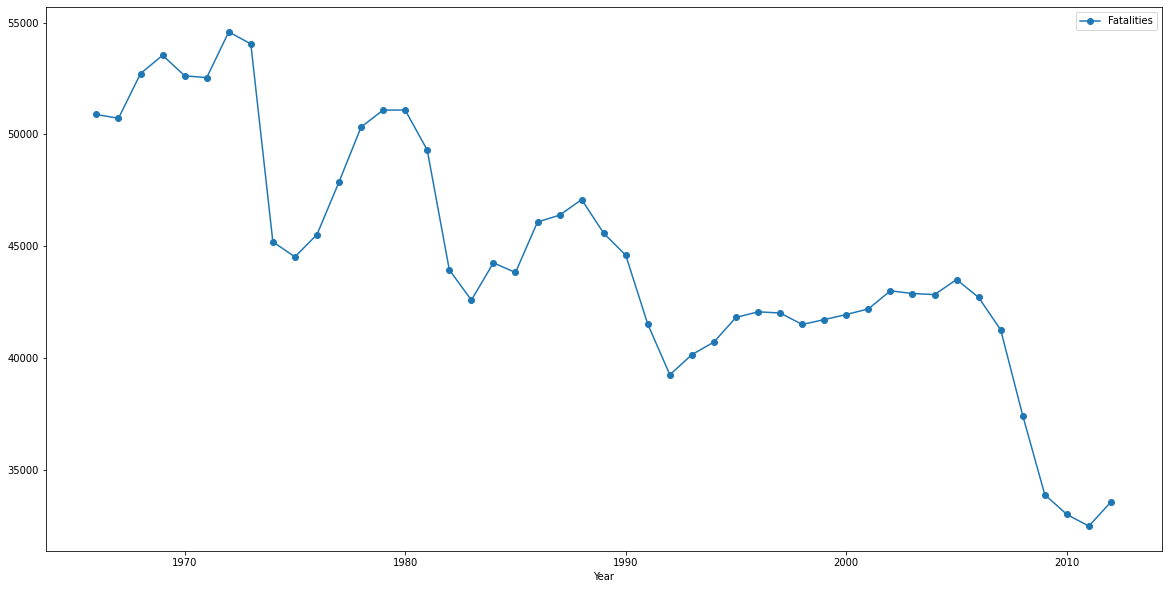

In [ ]:
data_df[['Fatalities']].plot(figsize=(20, 10), kind='line', marker='o')

[Text(0, 0, '1966'),
 Text(0, 0, '1968'),
 Text(0, 0, '1970'),
 Text(0, 0, '1972'),
 Text(0, 0, '1974'),
 Text(0, 0, '1976'),
 Text(0, 0, '1978'),
 Text(0, 0, '1980'),
 Text(0, 0, '1982'),
 Text(0, 0, '1984'),
 Text(0, 0, '1986'),
 Text(0, 0, '1988'),
 Text(0, 0, '1990'),
 Text(0, 0, '1992'),
 Text(0, 0, '1994'),
 Text(0, 0, '1996'),
 Text(0, 0, '1998'),
 Text(0, 0, '2000'),
 Text(0, 0, '2002'),
 Text(0, 0, '2004'),
 Text(0, 0, '2006'),
 Text(0, 0, '2008'),
 Text(0, 0, '2010'),
 Text(0, 0, '2012')]

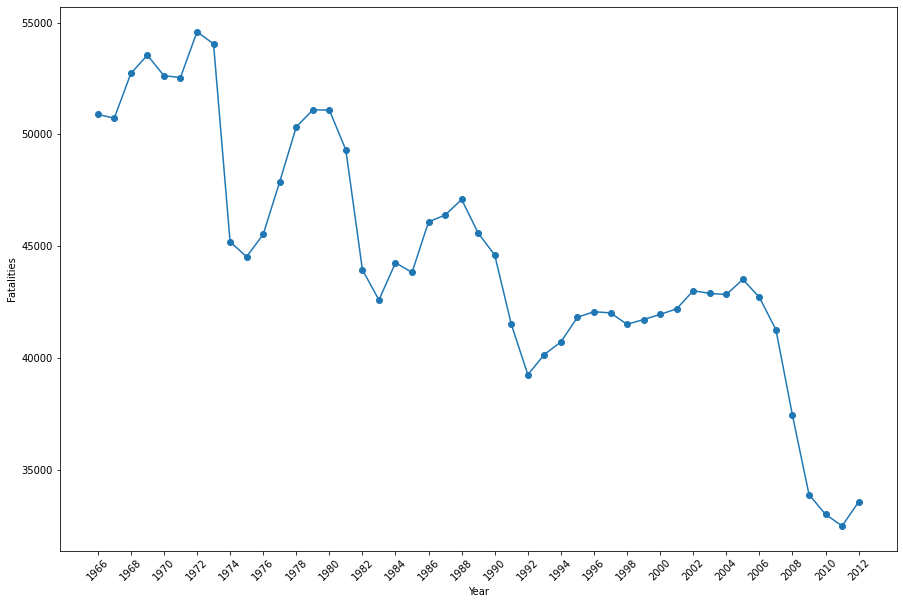

In [ ]:
x = data['Year'].tolist()
y = data['Fatalities'].tolist()

fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(x, y, marker='o')
ax.set_xlabel('Year')
ax.set_ylabel('Fatalities')
ax.set_xticks(x[::2])
ax.set_xticklabels(x[::2], rotation=45)

**ACF**

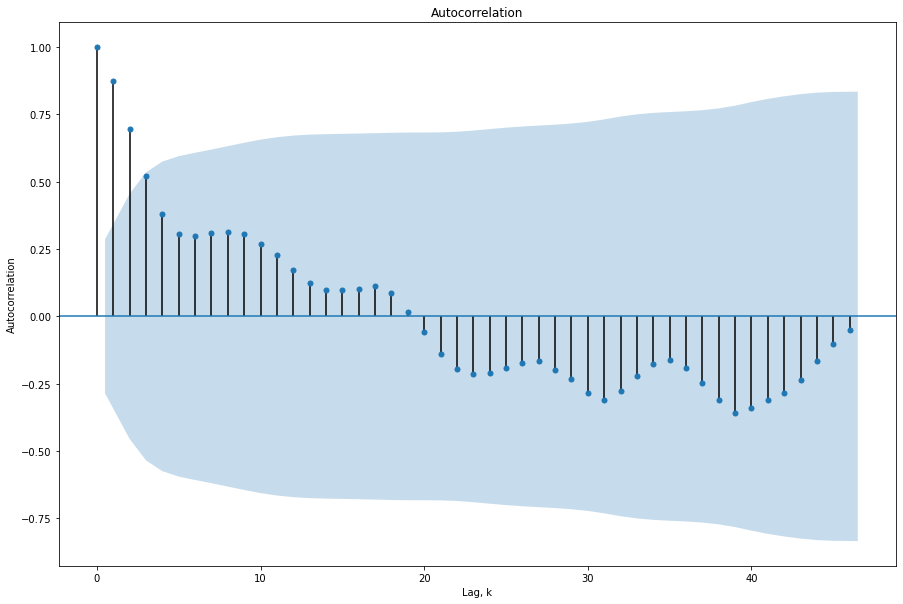

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 10))
sm.graphics.tsa.plot_acf(data['Fatalities'], ax=ax1, lags=46)
ax1.set_xlabel("Lag, k")
ax1.set_ylabel("Autocorrelation")
plt.show()

In [ ]:
acf = sm.tsa.stattools.acf(data['Fatalities'], nlags=40)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



In [ ]:
acf

array([ 1.        ,  0.87416465,  0.69463774,  0.52120446,  0.37910096,
        0.30628121,  0.29728484,  0.31074811,  0.31317225,  0.30459671,
        0.2673514 ,  0.22640964,  0.17037822,  0.12228895,  0.09719869,
        0.09708616,  0.10308481,  0.1125786 ,  0.08831616,  0.0165329 ,
       -0.05859725, -0.14015765, -0.19346133, -0.21571101, -0.21157819,
       -0.19328617, -0.17324494, -0.16531721, -0.19731195, -0.23273718,
       -0.28281359, -0.30918338, -0.27526947, -0.22026513, -0.17489141,
       -0.16265557, -0.19286267, -0.24801454, -0.30991117, -0.35929367,
       -0.3407296 ])

In [ ]:
lags = range(1, len(acf))
acf_series = pd.DataFrame(list(zip(lags, acf)), columns=["Lags", "ACF"])

In [ ]:
acf_series.head(10)

,Lags,ACF
0,1,1.000000
1,2,0.874165
2,3,0.694638
3,4,0.521204
4,5,0.379101
5,6,0.306281
6,7,0.297285
7,8,0.310748
8,9,0.313172
9,10,0.304597


In [ ]:
import skgstat as skg

**Variogram**

In [ ]:
V = skg.Variogram(x, y)

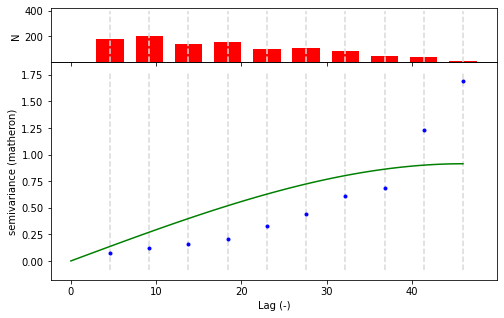

In [ ]:
V.plot()
plt.show()

# **Problem 2.32**

**Reconsider the motor vehicle fatality data from Exercise 2.31.**

**a. Plot the first difference of the data and comment on any features that you observe from the graph. Calculate and plot the sample ACF and variogram for the differenced data. Interpret these graphs. What impact did differencing have?**

**b. Compute a six-period moving average for the differenced data. Plot the moving average and the original data on the same axes. Does it seem that the six-period moving average would be a good forecasting technique for the differenced data?**

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, acf, plot_pacf
!pip install scikit-gstat
import skgstat as skg

In [ ]:
data_2_32 = pd.read_csv("https://github.com/pthnhan/DS_KHTN_TimeSeries/raw/main/data/Table%20B.25-US%20Motor%20Vehicle%20Traffic%20Fatalities.csv").set_index("Year")
display(data_2_32.shape)
data_2_32

(47, 6)

,Fatalities,Resident Population (Thousands),Licensed Drivers (Thousands),Registered Motor Vehicles (Thousands),Vehicle Miles Traveled (Billions),Annual Unemplyment Rate (%)
Year,,,,,,
1966,50894,196560,100998,95703,926,3.8
1967,50724,198712,103172,98859,964,3.8
1968,52725,200706,105410,102987,1016,3.6
1969,53543,202677,108306,107412,1062,3.5
1970,52627,205052,111543,111242,1110,4.9
1971,52542,207661,114426,116330,1179,5.9
1972,54589,209896,118414,122557,1260,5.6
1973,54052,211909,121546,130025,1313,4.9
1974,45196,213854,125427,134900,1281,5.6


**a.**

**Plot the first difference of the data and comment on any features that you observe from the graph**

In [ ]:
data_2_32_firstdiff = data_2_32.diff().dropna()
data_2_32_firstdiff

,Fatalities,Resident Population (Thousands),Licensed Drivers (Thousands),Registered Motor Vehicles (Thousands),Vehicle Miles Traveled (Billions),Annual Unemplyment Rate (%)
Year,,,,,,
1967,-170.0,2152.0,2174.0,3156.0,38.0,0.0
1968,2001.0,1994.0,2238.0,4128.0,52.0,-0.2
1969,818.0,1971.0,2896.0,4425.0,46.0,-0.1
1970,-916.0,2375.0,3237.0,3830.0,48.0,1.4
1971,-85.0,2609.0,2883.0,5088.0,69.0,1.0
1972,2047.0,2235.0,3988.0,6227.0,81.0,-0.3
1973,-537.0,2013.0,3132.0,7468.0,53.0,-0.7
1974,-8856.0,1945.0,3881.0,4875.0,-32.0,0.7
1975,-671.0,2119.0,4364.0,-8747.0,47.0,2.9


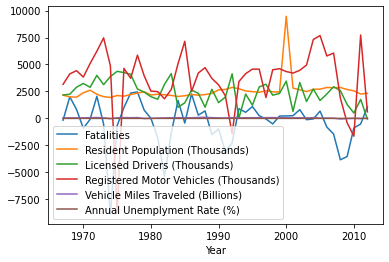

In [ ]:
data_2_32_firstdiff.plot()
plt.show()

**ACF**

[ 1.00000000e+00  3.06547351e-01 -1.22271229e-01 -2.50461171e-01
 -3.15454671e-01 -2.78594079e-01 -1.80013106e-01  1.19827586e-01
  3.26843706e-01  2.28318818e-01 -1.10870560e-02 -3.14769769e-02
 -1.80177108e-01 -2.37349224e-01 -2.27166578e-01  1.78295156e-02
  1.39313103e-01  2.67776845e-01  2.14834339e-01 -1.43473481e-02
 -1.06894944e-01 -1.16376128e-01 -9.87450871e-02 -1.07085246e-01
  4.11304422e-04  4.09386146e-02  1.41944138e-01  1.25068372e-01
  1.76149890e-02 -4.27788308e-02 -1.25594099e-01 -1.49373958e-01
 -4.24728748e-02  5.85463514e-02  1.86638454e-01  1.52479520e-01
  2.48624098e-03 -2.69505300e-02 -7.66230476e-02 -3.01816610e-02
 -4.40659257e-02 -4.34463396e-02 -1.46793743e-02  6.75977894e-03
  1.79159487e-02  1.57161781e-03]


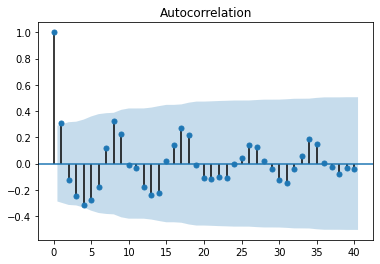

In [ ]:
acf_firstdiff = sm.tsa.stattools.acf(data_2_32_firstdiff['Fatalities'], nlags = len(data_2_32_firstdiff)-1,fft=False)
print(acf_firstdiff)
plot_acf(data_2_32_firstdiff['Fatalities'], lags=40)
plt.show()

**Variogram**

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   3.74
Sill:              4262870.22
Nugget:            0.00
        


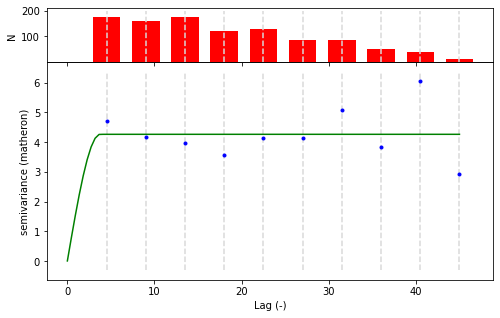

In [ ]:
v_firstdiff = skg.Variogram(data_2_32_firstdiff.index.tolist(), data_2_32_firstdiff['Fatalities'].tolist())
print(v_firstdiff)
v_firstdiff.plot()
plt.show()

**Interpret these graphs. What impact did differencing have?**

**Trả lời**

...

**b.**

**Compute a six-period moving average for the differenced data**

In [ ]:
data_2_32_firstdiff['MA_6'] = data_2_32_firstdiff['Fatalities'].rolling(window=6).mean()
data_2_32_firstdiff =data_2_32_firstdiff.dropna()
data_2_32_firstdiff

,Fatalities,Resident Population (Thousands),Licensed Drivers (Thousands),Registered Motor Vehicles (Thousands),Vehicle Miles Traveled (Billions),Annual Unemplyment Rate (%),MA_6
Year,,,,,,,
1972,2047.0,2235.0,3988.0,6227.0,81.0,-0.3,615.833333
1973,-537.0,2013.0,3132.0,7468.0,53.0,-0.7,554.666667
1974,-8856.0,1945.0,3881.0,4875.0,-32.0,0.7,-1254.833333
1975,-671.0,2119.0,4364.0,-8747.0,47.0,2.9,-1503.000000
1976,998.0,2062.0,4245.0,4640.0,74.0,-0.8,-1184.000000
1977,2355.0,2204.0,4085.0,3721.0,65.0,-0.6,-777.333333
1978,2453.0,2346.0,2723.0,5860.0,78.0,-1.0,-709.666667
1979,762.0,2470.0,2440.0,3943.0,-16.0,-0.3,-493.166667
1980,-2.0,2170.0,2011.0,2528.0,-2.0,1.3,982.500000


**Plot the moving average and the original data on the same axes**

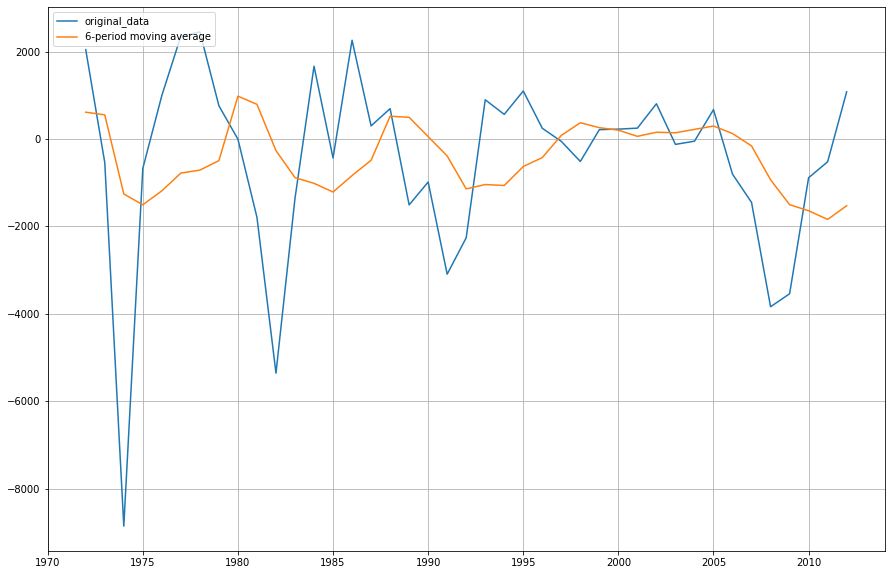

In [ ]:
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(data_2_32_firstdiff['Fatalities'], label='original_data')
plt.plot(data_2_32_firstdiff['MA_6'], label='6-period moving average')
plt.legend(loc=2)
plt.show()

**Does it seem that the six-period moving average would be a good forecasting technique for the differenced data?**

**Trả lời**

No. The six-period moving average would not be a good forecasting technique for the differenced data

# **Problem 2.44**

**Table E2.1 contains 40 one-step-ahead forecast errors from a forecasting model.**

**Find the sample ACF of the forecast errors. Interpret the results.**

**b. Construct a normal probability plot of the forecast errors. Is there evidence to support a claim that the forecast errors are normally distributed?**

**c. Find the mean error, the mean squared error, and the mean absolute deviation. Is it likely that the forecasting technique produces unbiased forecasts?**